In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)


<module 'libs.params' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/params.py'>

In [2]:
import matplotlib
# matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

# import multiprocessing as mp
# mp.set_start_method('spawn', force=True)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


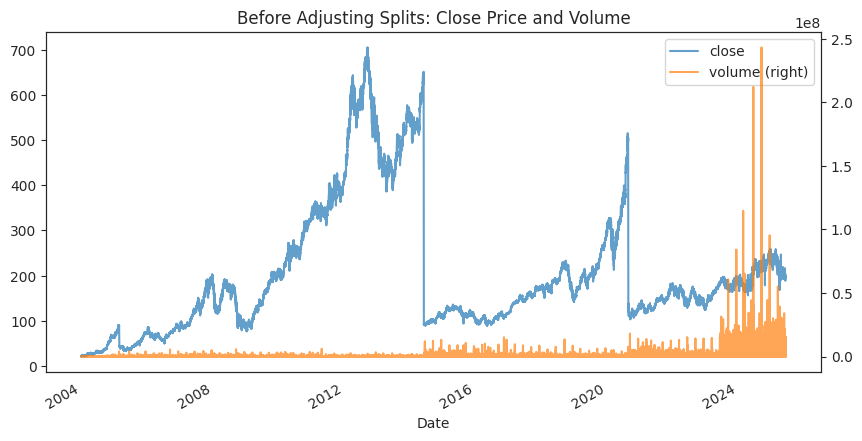

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


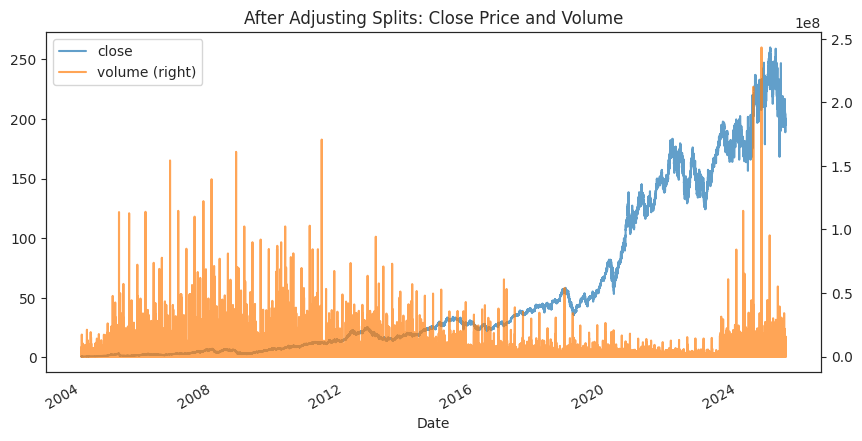

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder                   = params.stocks_folder,
    ticker                   = ticker,
    bidasktoclose_spread     = params.bidasktoclose_spread
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df                    = df_raw,
    regular_start_shifted = params.regular_start_premarket, # regular_start_shifted,
    regular_start         = params.regular_start,
    regular_end           = params.regular_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back,
        60
    ))
    regular_start_shifted = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back*2,
        60
    ))

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',
        min_prof_thr             = min_prof_thr,
        max_down_prop            = max_down_prop,
        gain_tightening_factor   = gain_tightening_factor,
        merging_retracement_thr  = merging_retracement_thr,
        merging_time_gap_thr     = merging_time_gap_thr,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
# calculate all possible look_backs, and create a list to use in the objective function,
# considering that it must be less than half time difference between regular_start and the first available timestamp

# 1) grab most common first timestamp’s time
first_times = df.index.to_series().groupby(df.index.normalize()).min().dt.time
first_time  = first_times.mode()[0]

# 2) convert to minutes since midnight
first_minutes   = first_time.hour * 60 + first_time.minute
start_minutes   = params.regular_start.hour * 60 + params.regular_start.minute

# 3) compute half the interval
diff_minutes  = start_minutes - first_minutes         # e.g. 14:30 − 11:30 = 330
half_minutes  = diff_minutes / 2                      # → 165.0

# 4) how many full 30-min chunks fit below half_minutes?
n_steps = int(half_minutes // 30)                     # floor(165/30) = 5

# 5) build list of multiples
look_backs = [30 * i for i in range(1, n_steps + 1)]   # → [30, 60, 90, 120, 150]




def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", look_backs),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.05, 1),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.05, 1),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 2),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.05, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.05, 1),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.5, 5),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.05, 1),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.01, 0.3),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.02, 0.8),
    }

    print('---------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl

print('first_time', first_time)
print('look_backs', look_backs)

first_time 09:00:00
look_backs [30, 60, 90, 120, 150]


[I 2025-08-13 09:39:36,695] A new study created in RDB with name: no-name-65babaec-4160-4740-ae7e-de21480304dc


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:41:47,091] Trial 0 finished with value: 0.31510333333333335 and parameters: {'look_back': 60, 'min_prof_thr': 0.9447898434511853, 'max_down_prop': 0.9258504815708586, 'gain_tightening_factor': 0.8206879870648675, 'merging_retracement_thr': 0.9081927041394934, 'merging_time_gap_thr': 0.8466252317292158, 'pre_entry_decay': 0.689349166578962, 'short_penalty': 0.9283892442349715, 'trailing_stop_thresh': 0.04205296873878697, 'buy_threshold': 0.5595763714580729}. Best is trial 0 with value: 0.31510333333333335.


→ Total return across 5400 trading days: $1701.56
→ Avg daily return (all days)          : $0.3151
→ Total trades                          : 8737
→ Avg return per trade                  : $0.1948



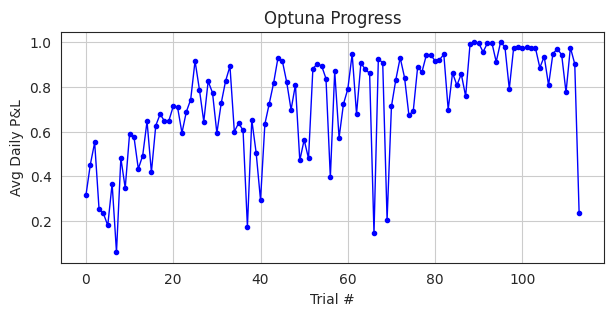

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:44:28,254] Trial 1 finished with value: 0.45182722222222216 and parameters: {'look_back': 120, 'min_prof_thr': 0.7578061846340719, 'max_down_prop': 0.5618450731203627, 'gain_tightening_factor': 0.7910369236805765, 'merging_retracement_thr': 0.3024741440249276, 'merging_time_gap_thr': 0.6610211339523684, 'pre_entry_decay': 0.2228440197683329, 'short_penalty': 0.5104353412609597, 'trailing_stop_thresh': 0.1326036818923404, 'buy_threshold': 0.34047473526028227}. Best is trial 1 with value: 0.45182722222222216.


→ Total return across 5400 trading days: $2439.87
→ Avg daily return (all days)          : $0.4518
→ Total trades                          : 8209
→ Avg return per trade                  : $0.2972

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:46:53,594] Trial 2 finished with value: 0.551261111111111 and parameters: {'look_back': 60, 'min_prof_thr': 0.378632331879065, 'max_down_prop': 0.6638754291945038, 'gain_tightening_factor': 0.368612198720367, 'merging_retracement_thr': 0.8967977102997324, 'merging_time_gap_thr': 0.8362571232122176, 'pre_entry_decay': 0.6926222506844629, 'short_penalty': 0.8841411649312968, 'trailing_stop_thresh': 0.1864790328691646, 'buy_threshold': 0.22344952744302338}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $2976.81
→ Avg daily return (all days)          : $0.5513
→ Total trades                          : 16233
→ Avg return per trade                  : $0.1834

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:49:36,827] Trial 3 finished with value: 0.2546796296296296 and parameters: {'look_back': 120, 'min_prof_thr': 0.8645554177942432, 'max_down_prop': 0.3503459070982707, 'gain_tightening_factor': 0.9978290609379411, 'merging_retracement_thr': 0.2999804710154789, 'merging_time_gap_thr': 0.4998225522075602, 'pre_entry_decay': 1.7803167608119863, 'short_penalty': 0.34906175018806873, 'trailing_stop_thresh': 0.07118477795814292, 'buy_threshold': 0.04424665584557607}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $1375.27
→ Avg daily return (all days)          : $0.2547
→ Total trades                          : 3862
→ Avg return per trade                  : $0.3561

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:53:31,607] Trial 4 finished with value: 0.23465314814814814 and parameters: {'look_back': 150, 'min_prof_thr': 0.0986726807918143, 'max_down_prop': 0.6747008651125925, 'gain_tightening_factor': 0.4837810111990827, 'merging_retracement_thr': 0.12388150973960475, 'merging_time_gap_thr': 0.622929840777541, 'pre_entry_decay': 1.7283162664543006, 'short_penalty': 0.9123695306914424, 'trailing_stop_thresh': 0.17679347244742968, 'buy_threshold': 0.6776626478853902}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $1267.13
→ Avg daily return (all days)          : $0.2347
→ Total trades                          : 4177
→ Avg return per trade                  : $0.3034

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:56:26,783] Trial 5 finished with value: 0.18045462962962963 and parameters: {'look_back': 150, 'min_prof_thr': 0.7951436025882608, 'max_down_prop': 0.14766901829767415, 'gain_tightening_factor': 0.4603928116628039, 'merging_retracement_thr': 0.3297384803357387, 'merging_time_gap_thr': 0.36053131245883696, 'pre_entry_decay': 1.873185114818878, 'short_penalty': 0.7113908090551739, 'trailing_stop_thresh': 0.16133417707225212, 'buy_threshold': 0.5925390192879559}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $974.46
→ Avg daily return (all days)          : $0.1805
→ Total trades                          : 2660
→ Avg return per trade                  : $0.3663

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 09:59:04,142] Trial 6 finished with value: 0.3666657407407407 and parameters: {'look_back': 60, 'min_prof_thr': 0.2422208072659045, 'max_down_prop': 0.06370620869758552, 'gain_tightening_factor': 0.484609087889519, 'merging_retracement_thr': 0.528019827916565, 'merging_time_gap_thr': 0.6206384526403057, 'pre_entry_decay': 0.24601187768422025, 'short_penalty': 0.8624219050069147, 'trailing_stop_thresh': 0.01059759945890881, 'buy_threshold': 0.645659332198231}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $1979.99
→ Avg daily return (all days)          : $0.3667
→ Total trades                          : 12987
→ Avg return per trade                  : $0.1525

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:01:09,106] Trial 7 finished with value: 0.06101444444444445 and parameters: {'look_back': 30, 'min_prof_thr': 0.918722800802899, 'max_down_prop': 0.06322500656377458, 'gain_tightening_factor': 0.11239916539954098, 'merging_retracement_thr': 0.47778975111550337, 'merging_time_gap_thr': 0.2962124005990864, 'pre_entry_decay': 1.8369229084139533, 'short_penalty': 0.18466376616199887, 'trailing_stop_thresh': 0.022006125794621363, 'buy_threshold': 0.37732795368806904}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $329.48
→ Avg daily return (all days)          : $0.0610
→ Total trades                          : 664
→ Avg return per trade                  : $0.4962

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:03:29,654] Trial 8 finished with value: 0.48136074074074076 and parameters: {'look_back': 30, 'min_prof_thr': 0.5734989771991553, 'max_down_prop': 0.9646530155975634, 'gain_tightening_factor': 0.3795127607195938, 'merging_retracement_thr': 0.07949979545786141, 'merging_time_gap_thr': 0.4704114822292431, 'pre_entry_decay': 0.4325410465303593, 'short_penalty': 0.3208932926214927, 'trailing_stop_thresh': 0.09900880146098172, 'buy_threshold': 0.08949220379571123}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $2599.35
→ Avg daily return (all days)          : $0.4814
→ Total trades                          : 11359
→ Avg return per trade                  : $0.2288

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:06:41,809] Trial 9 finished with value: 0.3476301851851852 and parameters: {'look_back': 150, 'min_prof_thr': 0.9073782498830503, 'max_down_prop': 0.3418565854321467, 'gain_tightening_factor': 0.13139997774317527, 'merging_retracement_thr': 0.259833849310272, 'merging_time_gap_thr': 0.8395313312722565, 'pre_entry_decay': 1.4606361369934615, 'short_penalty': 0.8716523386415049, 'trailing_stop_thresh': 0.07531708359050562, 'buy_threshold': 0.21556892218428692}. Best is trial 2 with value: 0.551261111111111.


→ Total return across 5400 trading days: $1877.20
→ Avg daily return (all days)          : $0.3476
→ Total trades                          : 5712
→ Avg return per trade                  : $0.3286

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:09:16,433] Trial 10 finished with value: 0.5903961111111112 and parameters: {'look_back': 90, 'min_prof_thr': 0.3828845978929971, 'max_down_prop': 0.7544298473837412, 'gain_tightening_factor': 0.3084074411180382, 'merging_retracement_thr': 0.9983227260707523, 'merging_time_gap_thr': 0.06836832767456802, 'pre_entry_decay': 0.9280035874405932, 'short_penalty': 0.653169967573623, 'trailing_stop_thresh': 0.19451561228979958, 'buy_threshold': 0.2669643485393346}. Best is trial 10 with value: 0.5903961111111112.


→ Total return across 5400 trading days: $3188.14
→ Avg daily return (all days)          : $0.5904
→ Total trades                          : 16464
→ Avg return per trade                  : $0.1936

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:12:00,778] Trial 11 finished with value: 0.5768759259259258 and parameters: {'look_back': 90, 'min_prof_thr': 0.37362962238348596, 'max_down_prop': 0.751764623283506, 'gain_tightening_factor': 0.26629074217532306, 'merging_retracement_thr': 0.9881647621408809, 'merging_time_gap_thr': 0.13198994570884148, 'pre_entry_decay': 1.0065696209972963, 'short_penalty': 0.6758249465853344, 'trailing_stop_thresh': 0.19668490371949282, 'buy_threshold': 0.2593162509049392}. Best is trial 10 with value: 0.5903961111111112.


→ Total return across 5400 trading days: $3115.13
→ Avg daily return (all days)          : $0.5769
→ Total trades                          : 16791
→ Avg return per trade                  : $0.1855

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:14:29,742] Trial 12 finished with value: 0.43333462962962965 and parameters: {'look_back': 90, 'min_prof_thr': 0.4643347286323852, 'max_down_prop': 0.8016157318809158, 'gain_tightening_factor': 0.22135674144764483, 'merging_retracement_thr': 0.7385351825114779, 'merging_time_gap_thr': 0.09347906777542847, 'pre_entry_decay': 1.1614622136695747, 'short_penalty': 0.6513191293420918, 'trailing_stop_thresh': 0.15127842993047783, 'buy_threshold': 0.4151683212454421}. Best is trial 10 with value: 0.5903961111111112.


→ Total return across 5400 trading days: $2340.01
→ Avg daily return (all days)          : $0.4333
→ Total trades                          : 9528
→ Avg return per trade                  : $0.2456

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:17:03,759] Trial 13 finished with value: 0.4922164814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.6086744054000603, 'max_down_prop': 0.7873340984727482, 'gain_tightening_factor': 0.2744872211373813, 'merging_retracement_thr': 0.9707661152178126, 'merging_time_gap_thr': 0.0894578949596461, 'pre_entry_decay': 1.1410199127944696, 'short_penalty': 0.5936456591630866, 'trailing_stop_thresh': 0.19909969539948638, 'buy_threshold': 0.2285398393702744}. Best is trial 10 with value: 0.5903961111111112.


→ Total return across 5400 trading days: $2657.97
→ Avg daily return (all days)          : $0.4922
→ Total trades                          : 11231
→ Avg return per trade                  : $0.2367

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:19:49,623] Trial 14 finished with value: 0.6460327777777778 and parameters: {'look_back': 90, 'min_prof_thr': 0.3119624044085608, 'max_down_prop': 0.7848741828999519, 'gain_tightening_factor': 0.6345796094724764, 'merging_retracement_thr': 0.7538387709653007, 'merging_time_gap_thr': 0.2000262843039488, 'pre_entry_decay': 0.829847866159566, 'short_penalty': 0.48557638598586483, 'trailing_stop_thresh': 0.11519078637033199, 'buy_threshold': 0.3016660474202651}. Best is trial 14 with value: 0.6460327777777778.


→ Total return across 5400 trading days: $3488.58
→ Avg daily return (all days)          : $0.6460
→ Total trades                          : 15784
→ Avg return per trade                  : $0.2210

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:23:06,522] Trial 15 finished with value: 0.4177118518518519 and parameters: {'look_back': 90, 'min_prof_thr': 0.20599063065879208, 'max_down_prop': 0.504897298718128, 'gain_tightening_factor': 0.6309588557856208, 'merging_retracement_thr': 0.7607709192454296, 'merging_time_gap_thr': 0.24869112576427385, 'pre_entry_decay': 0.8882484257224172, 'short_penalty': 0.4763615198613448, 'trailing_stop_thresh': 0.11737613402607855, 'buy_threshold': 0.4835315456527989}. Best is trial 14 with value: 0.6460327777777778.


→ Total return across 5400 trading days: $2255.64
→ Avg daily return (all days)          : $0.4177
→ Total trades                          : 7651
→ Avg return per trade                  : $0.2948

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:26:10,268] Trial 16 finished with value: 0.6267511111111111 and parameters: {'look_back': 90, 'min_prof_thr': 0.2825645320599056, 'max_down_prop': 0.8685639077961689, 'gain_tightening_factor': 0.6432357124267865, 'merging_retracement_thr': 0.7181736174321123, 'merging_time_gap_thr': 0.20456132569214852, 'pre_entry_decay': 1.292913305514965, 'short_penalty': 0.08291228078269347, 'trailing_stop_thresh': 0.1406876025694497, 'buy_threshold': 0.13162485909152297}. Best is trial 14 with value: 0.6460327777777778.


→ Total return across 5400 trading days: $3384.46
→ Avg daily return (all days)          : $0.6268
→ Total trades                          : 15410
→ Avg return per trade                  : $0.2196

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:29:45,217] Trial 17 finished with value: 0.6776794444444445 and parameters: {'look_back': 90, 'min_prof_thr': 0.0628161214722161, 'max_down_prop': 0.890317857891104, 'gain_tightening_factor': 0.6543931008694309, 'merging_retracement_thr': 0.6747408548725197, 'merging_time_gap_thr': 0.23735684102699772, 'pre_entry_decay': 1.389539888772681, 'short_penalty': 0.10168498509001284, 'trailing_stop_thresh': 0.09784287242452536, 'buy_threshold': 0.14131547936906974}. Best is trial 17 with value: 0.6776794444444445.


→ Total return across 5400 trading days: $3659.47
→ Avg daily return (all days)          : $0.6777
→ Total trades                          : 17676
→ Avg return per trade                  : $0.2070

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:33:19,514] Trial 18 finished with value: 0.6466966666666667 and parameters: {'look_back': 90, 'min_prof_thr': 0.07638571161972489, 'max_down_prop': 0.9920390159213157, 'gain_tightening_factor': 0.6331257537739681, 'merging_retracement_thr': 0.5533066467056854, 'merging_time_gap_thr': 0.38814629764554254, 'pre_entry_decay': 1.5228379860637555, 'short_penalty': 0.06346038869097381, 'trailing_stop_thresh': 0.10030494126999563, 'buy_threshold': 0.1296524120631093}. Best is trial 17 with value: 0.6776794444444445.


→ Total return across 5400 trading days: $3492.16
→ Avg daily return (all days)          : $0.6467
→ Total trades                          : 17118
→ Avg return per trade                  : $0.2040

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:36:54,102] Trial 19 finished with value: 0.648174074074074 and parameters: {'look_back': 90, 'min_prof_thr': 0.05418528101363866, 'max_down_prop': 0.9832531909562165, 'gain_tightening_factor': 0.7522545927688142, 'merging_retracement_thr': 0.5841122465590388, 'merging_time_gap_thr': 0.3922525771586395, 'pre_entry_decay': 1.5178531133475126, 'short_penalty': 0.05173994337267701, 'trailing_stop_thresh': 0.08487397580423614, 'buy_threshold': 0.15297655282028708}. Best is trial 17 with value: 0.6776794444444445.


→ Total return across 5400 trading days: $3500.14
→ Avg daily return (all days)          : $0.6482
→ Total trades                          : 16802
→ Avg return per trade                  : $0.2083

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:40:16,644] Trial 20 finished with value: 0.7126053703703704 and parameters: {'look_back': 120, 'min_prof_thr': 0.15348012426166008, 'max_down_prop': 0.8870504130287644, 'gain_tightening_factor': 0.7995861424855116, 'merging_retracement_thr': 0.6478731518275196, 'merging_time_gap_thr': 0.9687369475447356, 'pre_entry_decay': 1.5210279495698493, 'short_penalty': 0.19532137555125448, 'trailing_stop_thresh': 0.0725354972374451, 'buy_threshold': 0.1588788523354836}. Best is trial 20 with value: 0.7126053703703704.


→ Total return across 5400 trading days: $3848.07
→ Avg daily return (all days)          : $0.7126
→ Total trades                          : 19979
→ Avg return per trade                  : $0.1926

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:43:48,665] Trial 21 finished with value: 0.7078818518518518 and parameters: {'look_back': 120, 'min_prof_thr': 0.1637244161224201, 'max_down_prop': 0.8978931024762419, 'gain_tightening_factor': 0.8107086191488919, 'merging_retracement_thr': 0.6354180279722975, 'merging_time_gap_thr': 0.990381551820585, 'pre_entry_decay': 1.4937586107611516, 'short_penalty': 0.18895151715999017, 'trailing_stop_thresh': 0.07398887371242159, 'buy_threshold': 0.1602887660834389}. Best is trial 20 with value: 0.7126053703703704.


→ Total return across 5400 trading days: $3822.56
→ Avg daily return (all days)          : $0.7079
→ Total trades                          : 19656
→ Avg return per trade                  : $0.1945

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:47:02,211] Trial 22 finished with value: 0.5941507407407408 and parameters: {'look_back': 120, 'min_prof_thr': 0.14162621029200578, 'max_down_prop': 0.8862787532503441, 'gain_tightening_factor': 0.9874308962226674, 'merging_retracement_thr': 0.6458970910933619, 'merging_time_gap_thr': 0.9944808038868364, 'pre_entry_decay': 1.3659186712496294, 'short_penalty': 0.2023896966634797, 'trailing_stop_thresh': 0.05752521479132506, 'buy_threshold': 0.035319845493056376}. Best is trial 20 with value: 0.7126053703703704.


→ Total return across 5400 trading days: $3208.41
→ Avg daily return (all days)          : $0.5942
→ Total trades                          : 33433
→ Avg return per trade                  : $0.0960

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:50:08,768] Trial 23 finished with value: 0.6878768518518519 and parameters: {'look_back': 120, 'min_prof_thr': 0.1970433028541238, 'max_down_prop': 0.8657297389526719, 'gain_tightening_factor': 0.8847722459015259, 'merging_retracement_thr': 0.456795655612963, 'merging_time_gap_thr': 0.9445424202476363, 'pre_entry_decay': 1.6467180214958104, 'short_penalty': 0.18462595991619557, 'trailing_stop_thresh': 0.049595823375019096, 'buy_threshold': 0.17714180013526615}. Best is trial 20 with value: 0.7126053703703704.


→ Total return across 5400 trading days: $3714.54
→ Avg daily return (all days)          : $0.6879
→ Total trades                          : 19567
→ Avg return per trade                  : $0.1898

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:53:13,634] Trial 24 finished with value: 0.7428366666666666 and parameters: {'look_back': 120, 'min_prof_thr': 0.17636168551503034, 'max_down_prop': 0.6311215087106357, 'gain_tightening_factor': 0.885777581967375, 'merging_retracement_thr': 0.4330985141788477, 'merging_time_gap_thr': 0.9815523415425372, 'pre_entry_decay': 1.6318417106095675, 'short_penalty': 0.29880302196008357, 'trailing_stop_thresh': 0.03963191191088568, 'buy_threshold': 0.18187940094891722}. Best is trial 24 with value: 0.7428366666666666.


→ Total return across 5400 trading days: $4011.32
→ Avg daily return (all days)          : $0.7428
→ Total trades                          : 21874
→ Avg return per trade                  : $0.1834

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:56:30,697] Trial 25 finished with value: 0.9156101851851852 and parameters: {'look_back': 120, 'min_prof_thr': 0.15837011665770942, 'max_down_prop': 0.5716873824340107, 'gain_tightening_factor': 0.9066907157669264, 'merging_retracement_thr': 0.3843102845832396, 'merging_time_gap_thr': 0.7552954469184272, 'pre_entry_decay': 1.6403911856452298, 'short_penalty': 0.3449647564901692, 'trailing_stop_thresh': 0.02807979009373856, 'buy_threshold': 0.08149221163794154}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4944.30
→ Avg daily return (all days)          : $0.9156
→ Total trades                          : 43277
→ Avg return per trade                  : $0.1142

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 10:59:22,838] Trial 26 finished with value: 0.7874201851851853 and parameters: {'look_back': 120, 'min_prof_thr': 0.2973536843386917, 'max_down_prop': 0.42073354513778866, 'gain_tightening_factor': 0.9210716778818264, 'merging_retracement_thr': 0.3919120061552949, 'merging_time_gap_thr': 0.7288336764320102, 'pre_entry_decay': 1.9174048351783004, 'short_penalty': 0.33945981264108294, 'trailing_stop_thresh': 0.040628603480814485, 'buy_threshold': 0.06815505218642266}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4252.07
→ Avg daily return (all days)          : $0.7874
→ Total trades                          : 27121
→ Avg return per trade                  : $0.1568

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:02:03,252] Trial 27 finished with value: 0.6445755555555555 and parameters: {'look_back': 120, 'min_prof_thr': 0.4842065492056065, 'max_down_prop': 0.4436438508773862, 'gain_tightening_factor': 0.9116291233990287, 'merging_retracement_thr': 0.42583593068802766, 'merging_time_gap_thr': 0.7282545508973144, 'pre_entry_decay': 1.9356493015758587, 'short_penalty': 0.33610824988722293, 'trailing_stop_thresh': 0.028877750572839454, 'buy_threshold': 0.08504568482135455}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3480.71
→ Avg daily return (all days)          : $0.6446
→ Total trades                          : 16604
→ Avg return per trade                  : $0.2096

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:04:55,290] Trial 28 finished with value: 0.8244731481481483 and parameters: {'look_back': 120, 'min_prof_thr': 0.3127354181991905, 'max_down_prop': 0.5951243466555121, 'gain_tightening_factor': 0.9130949776827832, 'merging_retracement_thr': 0.3839427547677382, 'merging_time_gap_thr': 0.7510462788401806, 'pre_entry_decay': 1.9911004219314976, 'short_penalty': 0.399735387029748, 'trailing_stop_thresh': 0.03630025196481213, 'buy_threshold': 0.08218670339232115}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4452.16
→ Avg daily return (all days)          : $0.8245
→ Total trades                          : 30516
→ Avg return per trade                  : $0.1459

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:07:46,340] Trial 29 finished with value: 0.7735285185185186 and parameters: {'look_back': 120, 'min_prof_thr': 0.3066389903350223, 'max_down_prop': 0.359586768619881, 'gain_tightening_factor': 0.7312319587450318, 'merging_retracement_thr': 0.1825078905768578, 'merging_time_gap_thr': 0.7200294356727982, 'pre_entry_decay': 1.9700556901405073, 'short_penalty': 0.4303179003099885, 'trailing_stop_thresh': 0.03626245852342069, 'buy_threshold': 0.0724092375274308}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4177.05
→ Avg daily return (all days)          : $0.7735
→ Total trades                          : 26138
→ Avg return per trade                  : $0.1598

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:10:22,039] Trial 30 finished with value: 0.5929222222222221 and parameters: {'look_back': 120, 'min_prof_thr': 0.43426752096531374, 'max_down_prop': 0.26401097730536177, 'gain_tightening_factor': 0.9304161015401942, 'merging_retracement_thr': 0.37253216710028547, 'merging_time_gap_thr': 0.7773634267394857, 'pre_entry_decay': 1.9898061532924234, 'short_penalty': 0.39909814523640436, 'trailing_stop_thresh': 0.012424858784552371, 'buy_threshold': 0.10131672494253488}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3201.78
→ Avg daily return (all days)          : $0.5929
→ Total trades                          : 16191
→ Avg return per trade                  : $0.1978

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:13:16,198] Trial 31 finished with value: 0.7275044444444445 and parameters: {'look_back': 120, 'min_prof_thr': 0.2944364921972681, 'max_down_prop': 0.43983746251343275, 'gain_tightening_factor': 0.7309344861306066, 'merging_retracement_thr': 0.20077023815648856, 'merging_time_gap_thr': 0.7096279195775399, 'pre_entry_decay': 1.9934113248178946, 'short_penalty': 0.41699182812924457, 'trailing_stop_thresh': 0.03742806090374799, 'buy_threshold': 0.05010807332121474}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3928.52
→ Avg daily return (all days)          : $0.7275
→ Total trades                          : 25650
→ Avg return per trade                  : $0.1532

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:16:06,311] Trial 32 finished with value: 0.8259738888888889 and parameters: {'look_back': 120, 'min_prof_thr': 0.33040210511369794, 'max_down_prop': 0.5655355283590321, 'gain_tightening_factor': 0.8518318985196753, 'merging_retracement_thr': 0.18325019208838478, 'merging_time_gap_thr': 0.5862895535037679, 'pre_entry_decay': 1.707954146203519, 'short_penalty': 0.2580650316544565, 'trailing_stop_thresh': 0.05729633879646789, 'buy_threshold': 0.07825295264284733}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4460.26
→ Avg daily return (all days)          : $0.8260
→ Total trades                          : 26902
→ Avg return per trade                  : $0.1658

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:19:04,207] Trial 33 finished with value: 0.8918687037037036 and parameters: {'look_back': 120, 'min_prof_thr': 0.2511915542808554, 'max_down_prop': 0.5943282071525376, 'gain_tightening_factor': 0.8610573057311187, 'merging_retracement_thr': 0.3705315182196211, 'merging_time_gap_thr': 0.5623666656239601, 'pre_entry_decay': 1.6877814985216555, 'short_penalty': 0.24874811977557587, 'trailing_stop_thresh': 0.05504628030576569, 'buy_threshold': 0.10209920757402785}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4816.09
→ Avg daily return (all days)          : $0.8919
→ Total trades                          : 29791
→ Avg return per trade                  : $0.1617

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:21:22,323] Trial 34 finished with value: 0.5996988888888889 and parameters: {'look_back': 60, 'min_prof_thr': 0.6550908546801315, 'max_down_prop': 0.5670284403667291, 'gain_tightening_factor': 0.8466189806315743, 'merging_retracement_thr': 0.23725485225239595, 'merging_time_gap_thr': 0.5776424202338988, 'pre_entry_decay': 1.7005513038728375, 'short_penalty': 0.24420631629817094, 'trailing_stop_thresh': 0.05560842305697755, 'buy_threshold': 0.11674018374609889}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3238.37
→ Avg daily return (all days)          : $0.5997
→ Total trades                          : 12562
→ Avg return per trade                  : $0.2578

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:24:13,647] Trial 35 finished with value: 0.6381461111111112 and parameters: {'look_back': 120, 'min_prof_thr': 0.36982921411010694, 'max_down_prop': 0.5871524319710127, 'gain_tightening_factor': 0.9847237971656092, 'merging_retracement_thr': 0.32664777514372123, 'merging_time_gap_thr': 0.5546388235889925, 'pre_entry_decay': 1.764720055595602, 'short_penalty': 0.2528889660786211, 'trailing_stop_thresh': 0.059321143135353804, 'buy_threshold': 0.2018550932875527}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3445.99
→ Avg daily return (all days)          : $0.6381
→ Total trades                          : 15043
→ Avg return per trade                  : $0.2291

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:27:22,990] Trial 36 finished with value: 0.6050740740740742 and parameters: {'look_back': 120, 'min_prof_thr': 0.24476451654530118, 'max_down_prop': 0.5037358332252819, 'gain_tightening_factor': 0.5730404459733399, 'merging_retracement_thr': 0.2864115561630063, 'merging_time_gap_thr': 0.786343664812839, 'pre_entry_decay': 1.821439140691537, 'short_penalty': 0.5525589383853555, 'trailing_stop_thresh': 0.024164525959925298, 'buy_threshold': 0.030896396118659242}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3267.40
→ Avg daily return (all days)          : $0.6051
→ Total trades                          : 26980
→ Avg return per trade                  : $0.1211

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:29:19,559] Trial 37 finished with value: 0.17522 and parameters: {'look_back': 30, 'min_prof_thr': 0.9907078035319501, 'max_down_prop': 0.6912355143652418, 'gain_tightening_factor': 0.8478422518104691, 'merging_retracement_thr': 0.14721928020148303, 'merging_time_gap_thr': 0.8936814540064895, 'pre_entry_decay': 1.591109320851341, 'short_penalty': 0.26797029067745715, 'trailing_stop_thresh': 0.04795303536178514, 'buy_threshold': 0.5166733601539242}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $946.19
→ Avg daily return (all days)          : $0.1752
→ Total trades                          : 3169
→ Avg return per trade                  : $0.2986

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:31:39,988] Trial 38 finished with value: 0.6520229629629629 and parameters: {'look_back': 60, 'min_prof_thr': 0.531256484936798, 'max_down_prop': 0.6165106915062974, 'gain_tightening_factor': 0.7728013195984476, 'merging_retracement_thr': 0.3556010223630455, 'merging_time_gap_thr': 0.6614553466242112, 'pre_entry_decay': 1.7370249272123273, 'short_penalty': 0.37614341275800767, 'trailing_stop_thresh': 0.06366648026843189, 'buy_threshold': 0.10162279396959426}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3520.92
→ Avg daily return (all days)          : $0.6520
→ Total trades                          : 15894
→ Avg return per trade                  : $0.2215

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:35:03,150] Trial 39 finished with value: 0.5052718518518519 and parameters: {'look_back': 120, 'min_prof_thr': 0.24320802595481616, 'max_down_prop': 0.6931814135536216, 'gain_tightening_factor': 0.6926292366032787, 'merging_retracement_thr': 0.06389144256215773, 'merging_time_gap_thr': 0.4479439349678848, 'pre_entry_decay': 1.2823385267197662, 'short_penalty': 0.13967100096249468, 'trailing_stop_thresh': 0.017847181741573855, 'buy_threshold': 0.2623939154499846}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $2728.47
→ Avg daily return (all days)          : $0.5053
→ Total trades                          : 14485
→ Avg return per trade                  : $0.1884

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:38:37,241] Trial 40 finished with value: 0.29387296296296295 and parameters: {'look_back': 120, 'min_prof_thr': 0.12970744386438873, 'max_down_prop': 0.5233727757733423, 'gain_tightening_factor': 0.9514955311135246, 'merging_retracement_thr': 0.49716472985838056, 'merging_time_gap_thr': 0.635572714210838, 'pre_entry_decay': 1.8751009706179913, 'short_penalty': 0.14021638609240972, 'trailing_stop_thresh': 0.02944418681292628, 'buy_threshold': 0.3377002880059854}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $1586.91
→ Avg daily return (all days)          : $0.2939
→ Total trades                          : 5830
→ Avg return per trade                  : $0.2722

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:41:33,159] Trial 41 finished with value: 0.6337957407407407 and parameters: {'look_back': 120, 'min_prof_thr': 0.41637645195095496, 'max_down_prop': 0.44584355345527027, 'gain_tightening_factor': 0.8580106862854793, 'merging_retracement_thr': 0.39737962791152054, 'merging_time_gap_thr': 0.784455814612935, 'pre_entry_decay': 1.8723330881311377, 'short_penalty': 0.36095591046486464, 'trailing_stop_thresh': 0.04777906473099895, 'buy_threshold': 0.05990101498400668}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3422.50
→ Avg daily return (all days)          : $0.6338
→ Total trades                          : 17317
→ Avg return per trade                  : $0.1976

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:45:12,199] Trial 42 finished with value: 0.7245153703703704 and parameters: {'look_back': 150, 'min_prof_thr': 0.33721950060817196, 'max_down_prop': 0.3948295769077077, 'gain_tightening_factor': 0.9479125374676849, 'merging_retracement_thr': 0.38471990996257577, 'merging_time_gap_thr': 0.523174100553865, 'pre_entry_decay': 1.6867457477211552, 'short_penalty': 0.2848908799762939, 'trailing_stop_thresh': 0.08695892110732442, 'buy_threshold': 0.07891959051393992}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $3912.38
→ Avg daily return (all days)          : $0.7245
→ Total trades                          : 21114
→ Avg return per trade                  : $0.1853

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:48:37,112] Trial 43 finished with value: 0.8167038888888889 and parameters: {'look_back': 120, 'min_prof_thr': 0.24810330384652504, 'max_down_prop': 0.5515188132599097, 'gain_tightening_factor': 0.9032675597866011, 'merging_retracement_thr': 0.2852155454098463, 'merging_time_gap_thr': 0.6787721343506453, 'pre_entry_decay': 1.8052388805291848, 'short_penalty': 0.4563811887117395, 'trailing_stop_thresh': 0.033636410137783054, 'buy_threshold': 0.0701472012421669}. Best is trial 25 with value: 0.9156101851851852.


→ Total return across 5400 trading days: $4410.20
→ Avg daily return (all days)          : $0.8167
→ Total trades                          : 34748
→ Avg return per trade                  : $0.1269

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:52:01,353] Trial 44 finished with value: 0.9291440740740741 and parameters: {'look_back': 120, 'min_prof_thr': 0.24549350450788662, 'max_down_prop': 0.6382822277390752, 'gain_tightening_factor': 0.8087386660591657, 'merging_retracement_thr': 0.23977415274154007, 'merging_time_gap_thr': 0.5825963663688352, 'pre_entry_decay': 1.8382734722739071, 'short_penalty': 0.5395598841881254, 'trailing_stop_thresh': 0.03094296254324249, 'buy_threshold': 0.1187137523685655}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $5017.38
→ Avg daily return (all days)          : $0.9291
→ Total trades                          : 41578
→ Avg return per trade                  : $0.1207

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:54:54,753] Trial 45 finished with value: 0.9156794444444444 and parameters: {'look_back': 30, 'min_prof_thr': 0.10361324702729292, 'max_down_prop': 0.6446043217842033, 'gain_tightening_factor': 0.8162798869087607, 'merging_retracement_thr': 0.12205683236997233, 'merging_time_gap_thr': 0.595910774330553, 'pre_entry_decay': 1.5814543908061671, 'short_penalty': 0.548074695131653, 'trailing_stop_thresh': 0.01099434240078112, 'buy_threshold': 0.11314868541880034}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4944.67
→ Avg daily return (all days)          : $0.9157
→ Total trades                          : 49591
→ Avg return per trade                  : $0.0997

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:57:33,677] Trial 46 finished with value: 0.8209405555555555 and parameters: {'look_back': 30, 'min_prof_thr': 0.11740986404321649, 'max_down_prop': 0.6514768240851387, 'gain_tightening_factor': 0.8134967682667702, 'merging_retracement_thr': 0.09528456790911177, 'merging_time_gap_thr': 0.5910009320276349, 'pre_entry_decay': 1.5820213648891273, 'short_penalty': 0.5335469539649104, 'trailing_stop_thresh': 0.016154476768420654, 'buy_threshold': 0.1918636797844271}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4433.08
→ Avg daily return (all days)          : $0.8209
→ Total trades                          : 32384
→ Avg return per trade                  : $0.1369

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 11:59:56,172] Trial 47 finished with value: 0.6973875925925926 and parameters: {'look_back': 30, 'min_prof_thr': 0.21084998874915611, 'max_down_prop': 0.7177374797311797, 'gain_tightening_factor': 0.7155734674085611, 'merging_retracement_thr': 0.21510838444567798, 'merging_time_gap_thr': 0.4635880736333184, 'pre_entry_decay': 0.38835533958076196, 'short_penalty': 0.7937215895262506, 'trailing_stop_thresh': 0.023180882325851245, 'buy_threshold': 0.227516643774379}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $3765.89
→ Avg daily return (all days)          : $0.6974
→ Total trades                          : 34991
→ Avg return per trade                  : $0.1076

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:03:06,241] Trial 48 finished with value: 0.809015 and parameters: {'look_back': 30, 'min_prof_thr': 0.09659709988771553, 'max_down_prop': 0.6562652538355185, 'gain_tightening_factor': 0.5395339084689453, 'merging_retracement_thr': 0.1438489861029455, 'merging_time_gap_thr': 0.5167842624943786, 'pre_entry_decay': 1.3937758821751924, 'short_penalty': 0.6006386771274654, 'trailing_stop_thresh': 0.06612006071906441, 'buy_threshold': 0.12348109179962921}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4368.68
→ Avg daily return (all days)          : $0.8090
→ Total trades                          : 37569
→ Avg return per trade                  : $0.1163

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:06:02,444] Trial 49 finished with value: 0.47117611111111113 and parameters: {'look_back': 150, 'min_prof_thr': 0.7348919901509683, 'max_down_prop': 0.544311032823478, 'gain_tightening_factor': 0.7791388734702207, 'merging_retracement_thr': 0.25158828146869305, 'merging_time_gap_thr': 0.6134310966836166, 'pre_entry_decay': 1.74853505422351, 'short_penalty': 0.7458318229778528, 'trailing_stop_thresh': 0.08310451821244098, 'buy_threshold': 0.2960902564378939}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $2544.35
→ Avg daily return (all days)          : $0.4712
→ Total trades                          : 9364
→ Avg return per trade                  : $0.2717

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:08:32,119] Trial 50 finished with value: 0.5630231481481481 and parameters: {'look_back': 30, 'min_prof_thr': 0.21269808980175997, 'max_down_prop': 0.474095005891182, 'gain_tightening_factor': 0.4219882702133701, 'merging_retracement_thr': 0.10963585770544226, 'merging_time_gap_thr': 0.5478459351663185, 'pre_entry_decay': 0.12311046647370094, 'short_penalty': 0.5931745471076105, 'trailing_stop_thresh': 0.01098313826450912, 'buy_threshold': 0.10920899437167056}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $3040.32
→ Avg daily return (all days)          : $0.5630
→ Total trades                          : 33506
→ Avg return per trade                  : $0.0907

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:11:38,584] Trial 51 finished with value: 0.4798888888888889 and parameters: {'look_back': 120, 'min_prof_thr': 0.34751077453044166, 'max_down_prop': 0.6102896241752035, 'gain_tightening_factor': 0.8479988025164124, 'merging_retracement_thr': 0.3277900682979832, 'merging_time_gap_thr': 0.885910999997968, 'pre_entry_decay': 0.6966672786807464, 'short_penalty': 0.5115124871317347, 'trailing_stop_thresh': 0.027767819058853505, 'buy_threshold': 0.03276551693853951}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $2591.40
→ Avg daily return (all days)          : $0.4799
→ Total trades                          : 17714
→ Avg return per trade                  : $0.1463

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:14:09,885] Trial 52 finished with value: 0.8813727777777779 and parameters: {'look_back': 60, 'min_prof_thr': 0.2657093617791527, 'max_down_prop': 0.5886782807098031, 'gain_tightening_factor': 0.9604289696278381, 'merging_retracement_thr': 0.16165843602915667, 'merging_time_gap_thr': 0.4906171828333061, 'pre_entry_decay': 1.8310641835302608, 'short_penalty': 0.4503434392957481, 'trailing_stop_thresh': 0.047819378469407946, 'buy_threshold': 0.09203788328380566}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4759.41
→ Avg daily return (all days)          : $0.8814
→ Total trades                          : 34490
→ Avg return per trade                  : $0.1380

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:16:41,401] Trial 53 finished with value: 0.9017638888888888 and parameters: {'look_back': 60, 'min_prof_thr': 0.24759114672301358, 'max_down_prop': 0.7206691390120407, 'gain_tightening_factor': 0.969532372485136, 'merging_retracement_thr': 0.1567568311884589, 'merging_time_gap_thr': 0.4192156483662874, 'pre_entry_decay': 1.6153647083199574, 'short_penalty': 0.45953595592397434, 'trailing_stop_thresh': 0.04957789976151839, 'buy_threshold': 0.14248227235154723}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4869.52
→ Avg daily return (all days)          : $0.9018
→ Total trades                          : 33596
→ Avg return per trade                  : $0.1449

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:19:09,131] Trial 54 finished with value: 0.8937194444444444 and parameters: {'look_back': 60, 'min_prof_thr': 0.2699231935311256, 'max_down_prop': 0.7358296240817772, 'gain_tightening_factor': 0.9669641771602389, 'merging_retracement_thr': 0.052372688028449826, 'merging_time_gap_thr': 0.32354066876727766, 'pre_entry_decay': 1.595278837929793, 'short_penalty': 0.5616305882096473, 'trailing_stop_thresh': 0.047513195951707936, 'buy_threshold': 0.15703901110675691}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4826.09
→ Avg daily return (all days)          : $0.8937
→ Total trades                          : 34888
→ Avg return per trade                  : $0.1383

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:22:32,924] Trial 55 finished with value: 0.8366855555555557 and parameters: {'look_back': 60, 'min_prof_thr': 0.10571946257334124, 'max_down_prop': 0.7311331170825481, 'gain_tightening_factor': 0.9795738277742456, 'merging_retracement_thr': 0.07463457442790532, 'merging_time_gap_thr': 0.3162688390624184, 'pre_entry_decay': 1.2442139054832242, 'short_penalty': 0.9658693747431336, 'trailing_stop_thresh': 0.01995301831661076, 'buy_threshold': 0.15038278711866818}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4518.10
→ Avg daily return (all days)          : $0.8367
→ Total trades                          : 51761
→ Avg return per trade                  : $0.0873

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:25:08,952] Trial 56 finished with value: 0.39511222222222225 and parameters: {'look_back': 60, 'min_prof_thr': 0.18483421502152725, 'max_down_prop': 0.8327833411644108, 'gain_tightening_factor': 0.9964149931063192, 'merging_retracement_thr': 0.11660439840089566, 'merging_time_gap_thr': 0.34072501681498657, 'pre_entry_decay': 1.5806111808062864, 'short_penalty': 0.5831188937272682, 'trailing_stop_thresh': 0.044137141424696, 'buy_threshold': 0.42327394673843155}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $2133.61
→ Avg daily return (all days)          : $0.3951
→ Total trades                          : 9736
→ Avg return per trade                  : $0.2191

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:27:57,316] Trial 57 finished with value: 0.8687881481481483 and parameters: {'look_back': 60, 'min_prof_thr': 0.14872869640967765, 'max_down_prop': 0.7481544584780786, 'gain_tightening_factor': 0.8727988097960107, 'merging_retracement_thr': 0.21698154198715408, 'merging_time_gap_thr': 0.4244844229770073, 'pre_entry_decay': 1.4214445196138459, 'short_penalty': 0.6243748586378173, 'trailing_stop_thresh': 0.052989256331267304, 'buy_threshold': 0.16843753202058936}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4691.46
→ Avg daily return (all days)          : $0.8688
→ Total trades                          : 34427
→ Avg return per trade                  : $0.1363

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:30:24,423] Trial 58 finished with value: 0.5725364814814814 and parameters: {'look_back': 60, 'min_prof_thr': 0.21524643582056413, 'max_down_prop': 0.7858899206028555, 'gain_tightening_factor': 0.05772717695421009, 'merging_retracement_thr': 0.0504806753302634, 'merging_time_gap_thr': 0.40030395170767336, 'pre_entry_decay': 1.0786271891599315, 'short_penalty': 0.5039328078590242, 'trailing_stop_thresh': 0.1817685277150019, 'buy_threshold': 0.2171245220059138}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $3091.70
→ Avg daily return (all days)          : $0.5725
→ Total trades                          : 16473
→ Avg return per trade                  : $0.1877

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:32:46,577] Trial 59 finished with value: 0.7225298148148148 and parameters: {'look_back': 60, 'min_prof_thr': 0.4005373879824776, 'max_down_prop': 0.6795257807914236, 'gain_tightening_factor': 0.6910910371239014, 'merging_retracement_thr': 0.258682068619151, 'merging_time_gap_thr': 0.2968243790773952, 'pre_entry_decay': 1.4683820423216227, 'short_penalty': 0.6758689501217412, 'trailing_stop_thresh': 0.06661260344689593, 'buy_threshold': 0.13865165758583445}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $3901.66
→ Avg daily return (all days)          : $0.7225
→ Total trades                          : 22950
→ Avg return per trade                  : $0.1700

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:35:58,500] Trial 60 finished with value: 0.7899944444444443 and parameters: {'look_back': 60, 'min_prof_thr': 0.07629092218877653, 'max_down_prop': 0.8285287764747329, 'gain_tightening_factor': 0.822392083845056, 'merging_retracement_thr': 0.12686847082337466, 'merging_time_gap_thr': 0.25475820189795617, 'pre_entry_decay': 1.6090593244029285, 'short_penalty': 0.5526395025675788, 'trailing_stop_thresh': 0.02912107491420506, 'buy_threshold': 0.19560029989888467}. Best is trial 44 with value: 0.9291440740740741.


→ Total return across 5400 trading days: $4265.97
→ Avg daily return (all days)          : $0.7900
→ Total trades                          : 30001
→ Avg return per trade                  : $0.1422

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:40:49,481] Trial 61 finished with value: 0.9460003703703702 and parameters: {'look_back': 60, 'min_prof_thr': 0.2582436018444247, 'max_down_prop': 0.6512256696972359, 'gain_tightening_factor': 0.9552296022223702, 'merging_retracement_thr': 0.16078705744452282, 'merging_time_gap_thr': 0.4669267176781802, 'pre_entry_decay': 1.821290370761728, 'short_penalty': 0.45351434316237116, 'trailing_stop_thresh': 0.043275652918586295, 'buy_threshold': 0.12046308277645137}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $5108.40
→ Avg daily return (all days)          : $0.9460
→ Total trades                          : 37984
→ Avg return per trade                  : $0.1345

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:43:21,314] Trial 62 finished with value: 0.6785744444444444 and parameters: {'look_back': 60, 'min_prof_thr': 0.2730834829194195, 'max_down_prop': 0.63537684095064, 'gain_tightening_factor': 0.9551746107239089, 'merging_retracement_thr': 0.17417817814292383, 'merging_time_gap_thr': 0.35981411072642405, 'pre_entry_decay': 1.657660437073686, 'short_penalty': 0.4495587608057781, 'trailing_stop_thresh': 0.1673720997752708, 'buy_threshold': 0.24135261595715973}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $3664.30
→ Avg daily return (all days)          : $0.6786
→ Total trades                          : 14847
→ Avg return per trade                  : $0.2468

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:45:53,462] Trial 63 finished with value: 0.9056633333333334 and parameters: {'look_back': 60, 'min_prof_thr': 0.18473737006635524, 'max_down_prop': 0.7012334726638517, 'gain_tightening_factor': 0.8899355705247807, 'merging_retracement_thr': 0.09801978931313764, 'merging_time_gap_thr': 0.4941607979866336, 'pre_entry_decay': 1.5495491052668795, 'short_penalty': 0.4848191223305977, 'trailing_stop_thresh': 0.040920280009165845, 'buy_threshold': 0.12461530285327448}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4890.58
→ Avg daily return (all days)          : $0.9057
→ Total trades                          : 38620
→ Avg return per trade                  : $0.1266

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:48:27,200] Trial 64 finished with value: 0.8781253703703704 and parameters: {'look_back': 60, 'min_prof_thr': 0.1681737525737872, 'max_down_prop': 0.7107043284392941, 'gain_tightening_factor': 0.9206620139765523, 'merging_retracement_thr': 0.09042784271184576, 'merging_time_gap_thr': 0.4955940973153921, 'pre_entry_decay': 1.3454680768232414, 'short_penalty': 0.4758221993544782, 'trailing_stop_thresh': 0.04226582515514615, 'buy_threshold': 0.12421969379856665}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4741.88
→ Avg daily return (all days)          : $0.8781
→ Total trades                          : 37682
→ Avg return per trade                  : $0.1258

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:50:52,880] Trial 65 finished with value: 0.8598385185185187 and parameters: {'look_back': 60, 'min_prof_thr': 0.2234588893109743, 'max_down_prop': 0.7789478746328521, 'gain_tightening_factor': 0.8913285826159956, 'merging_retracement_thr': 0.13854862267404816, 'merging_time_gap_thr': 0.43843006967699055, 'pre_entry_decay': 1.5523227633823367, 'short_penalty': 0.5527315596161865, 'trailing_stop_thresh': 0.033941062572918027, 'buy_threshold': 0.16565601858232254}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4643.13
→ Avg daily return (all days)          : $0.8598
→ Total trades                          : 34728
→ Avg return per trade                  : $0.1337

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:53:34,533] Trial 66 finished with value: 0.14509037037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.13352779667675008, 'max_down_prop': 0.6663585654012598, 'gain_tightening_factor': 0.9391528692646851, 'merging_retracement_thr': 0.09789192203017741, 'merging_time_gap_thr': 0.48230802137953116, 'pre_entry_decay': 1.4558805190615036, 'short_penalty': 0.5130604200092842, 'trailing_stop_thresh': 0.01687530036188217, 'buy_threshold': 0.6874875892091444}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $783.49
→ Avg daily return (all days)          : $0.1451
→ Total trades                          : 2809
→ Avg return per trade                  : $0.2789

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:56:05,621] Trial 67 finished with value: 0.9262242592592592 and parameters: {'look_back': 60, 'min_prof_thr': 0.18146484757479747, 'max_down_prop': 0.7539712762536911, 'gain_tightening_factor': 0.9989817953259361, 'merging_retracement_thr': 0.050703812298443285, 'merging_time_gap_thr': 0.4085652404320848, 'pre_entry_decay': 1.8971785784431674, 'short_penalty': 0.6446546679081788, 'trailing_stop_thresh': 0.02401583469893854, 'buy_threshold': 0.1454906082522176}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $5001.61
→ Avg daily return (all days)          : $0.9262
→ Total trades                          : 43533
→ Avg return per trade                  : $0.1149

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 12:59:16,056] Trial 68 finished with value: 0.9061337037037037 and parameters: {'look_back': 150, 'min_prof_thr': 0.17938543664477896, 'max_down_prop': 0.8160982128411127, 'gain_tightening_factor': 0.9991696870243796, 'merging_retracement_thr': 0.20742898399979878, 'merging_time_gap_thr': 0.41083976612252887, 'pre_entry_decay': 1.9085113777924598, 'short_penalty': 0.6358722158650681, 'trailing_stop_thresh': 0.02242400584456592, 'buy_threshold': 0.14411569964577495}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4893.12
→ Avg daily return (all days)          : $0.9061
→ Total trades                          : 43048
→ Avg return per trade                  : $0.1137

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:03:05,429] Trial 69 finished with value: 0.20618259259259258 and parameters: {'look_back': 150, 'min_prof_thr': 0.05568430434391858, 'max_down_prop': 0.8104712337883855, 'gain_tightening_factor': 0.8217151383557966, 'merging_retracement_thr': 0.20465305726829403, 'merging_time_gap_thr': 0.3783162779883791, 'pre_entry_decay': 1.9070773246624713, 'short_penalty': 0.6893098465515491, 'trailing_stop_thresh': 0.024307814878540113, 'buy_threshold': 0.5984077101821489}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $1113.39
→ Avg daily return (all days)          : $0.2062
→ Total trades                          : 4430
→ Avg return per trade                  : $0.2513

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:06:17,618] Trial 70 finished with value: 0.7126466666666668 and parameters: {'look_back': 150, 'min_prof_thr': 0.18251136458793815, 'max_down_prop': 0.7608672688181132, 'gain_tightening_factor': 0.9996772042883404, 'merging_retracement_thr': 0.2881684310675751, 'merging_time_gap_thr': 0.5222061315387917, 'pre_entry_decay': 1.7833719462736044, 'short_penalty': 0.7396853767835668, 'trailing_stop_thresh': 0.0116183000467378, 'buy_threshold': 0.05994971324310367}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $3848.29
→ Avg daily return (all days)          : $0.7126
→ Total trades                          : 43059
→ Avg return per trade                  : $0.0894

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:09:44,417] Trial 71 finished with value: 0.8313150000000001 and parameters: {'look_back': 150, 'min_prof_thr': 0.11051224358365916, 'max_down_prop': 0.9447002385865372, 'gain_tightening_factor': 0.89161751734637, 'merging_retracement_thr': 0.152359758259496, 'merging_time_gap_thr': 0.41157349453766273, 'pre_entry_decay': 1.8922573223721713, 'short_penalty': 0.48369348502242915, 'trailing_stop_thresh': 0.03160548796947894, 'buy_threshold': 0.1395319796012101}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4489.10
→ Avg daily return (all days)          : $0.8313
→ Total trades                          : 34906
→ Avg return per trade                  : $0.1286

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:12:17,490] Trial 72 finished with value: 0.9297796296296297 and parameters: {'look_back': 30, 'min_prof_thr': 0.15418491823164338, 'max_down_prop': 0.6966369271795493, 'gain_tightening_factor': 0.933669751023909, 'merging_retracement_thr': 0.23256536298144878, 'merging_time_gap_thr': 0.46213646567632605, 'pre_entry_decay': 1.8424202348778813, 'short_penalty': 0.6425864308324937, 'trailing_stop_thresh': 0.022622177469682488, 'buy_threshold': 0.11391250341664527}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $5020.81
→ Avg daily return (all days)          : $0.9298
→ Total trades                          : 50851
→ Avg return per trade                  : $0.0987

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:14:34,824] Trial 73 finished with value: 0.8413809259259258 and parameters: {'look_back': 30, 'min_prof_thr': 0.15012895978757163, 'max_down_prop': 0.6402797695074592, 'gain_tightening_factor': 0.9321219374221846, 'merging_retracement_thr': 0.8631914055321052, 'merging_time_gap_thr': 0.46058008969758474, 'pre_entry_decay': 1.840243233625317, 'short_penalty': 0.6353794060402138, 'trailing_stop_thresh': 0.0215906584884911, 'buy_threshold': 0.18021571169209089}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4543.46
→ Avg daily return (all days)          : $0.8414
→ Total trades                          : 35023
→ Avg return per trade                  : $0.1297

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:16:54,543] Trial 74 finished with value: 0.6731744444444444 and parameters: {'look_back': 30, 'min_prof_thr': 0.18581401674679762, 'max_down_prop': 0.8507484856476542, 'gain_tightening_factor': 0.9183754604120035, 'merging_retracement_thr': 0.226571097495379, 'merging_time_gap_thr': 0.5366525100315906, 'pre_entry_decay': 1.9378144394709238, 'short_penalty': 0.7178684731443603, 'trailing_stop_thresh': 0.11973302706218038, 'buy_threshold': 0.11727437467665097}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $3635.14
→ Avg daily return (all days)          : $0.6732
→ Total trades                          : 34865
→ Avg return per trade                  : $0.1043

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:19:26,382] Trial 75 finished with value: 0.6923846296296297 and parameters: {'look_back': 30, 'min_prof_thr': 0.15292318389609594, 'max_down_prop': 0.6844255606994392, 'gain_tightening_factor': 0.7722353558973213, 'merging_retracement_thr': 0.19633535100493493, 'merging_time_gap_thr': 0.6404814456401798, 'pre_entry_decay': 1.7573109274336933, 'short_penalty': 0.6518077527496713, 'trailing_stop_thresh': 0.014763418758576743, 'buy_threshold': 0.05226417292148387}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $3738.88
→ Avg daily return (all days)          : $0.6924
→ Total trades                          : 45069
→ Avg return per trade                  : $0.0830

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:22:11,940] Trial 76 finished with value: 0.8876292592592592 and parameters: {'look_back': 30, 'min_prof_thr': 0.09595685469425089, 'max_down_prop': 0.7604684120592238, 'gain_tightening_factor': 0.8782146150486134, 'merging_retracement_thr': 0.26778487792651345, 'merging_time_gap_thr': 0.3804078140708326, 'pre_entry_decay': 1.9400715914216813, 'short_penalty': 0.6251074459763944, 'trailing_stop_thresh': 0.025628941564348886, 'buy_threshold': 0.09743376238018167}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4793.20
→ Avg daily return (all days)          : $0.8876
→ Total trades                          : 52176
→ Avg return per trade                  : $0.0919

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:26:35,075] Trial 77 finished with value: 0.8667762962962963 and parameters: {'look_back': 150, 'min_prof_thr': 0.08080544268111806, 'max_down_prop': 0.664531213200995, 'gain_tightening_factor': 0.8342562671901848, 'merging_retracement_thr': 0.12153460868395263, 'merging_time_gap_thr': 0.6040852589692758, 'pre_entry_decay': 1.855083286213406, 'short_penalty': 0.7804528185830908, 'trailing_stop_thresh': 0.0198504328811105, 'buy_threshold': 0.20258629385229282}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4680.59
→ Avg daily return (all days)          : $0.8668
→ Total trades                          : 38007
→ Avg return per trade                  : $0.1232

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:29:31,740] Trial 78 finished with value: 0.94219 and parameters: {'look_back': 30, 'min_prof_thr': 0.12444506417348176, 'max_down_prop': 0.6284440257066511, 'gain_tightening_factor': 0.9997515111529194, 'merging_retracement_thr': 0.30869699319786137, 'merging_time_gap_thr': 0.4364877941749179, 'pre_entry_decay': 1.7964597681276102, 'short_penalty': 0.5802073169176833, 'trailing_stop_thresh': 0.041190103264263506, 'buy_threshold': 0.11143120670305875}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $5087.83
→ Avg daily return (all days)          : $0.9422
→ Total trades                          : 45699
→ Avg return per trade                  : $0.1113

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:32:48,656] Trial 79 finished with value: 0.942336111111111 and parameters: {'look_back': 30, 'min_prof_thr': 0.1273611743852057, 'max_down_prop': 0.16218109688507149, 'gain_tightening_factor': 0.9987918339296343, 'merging_retracement_thr': 0.30896133610842413, 'merging_time_gap_thr': 0.3588301289345961, 'pre_entry_decay': 1.7143167562800252, 'short_penalty': 0.5806015396455178, 'trailing_stop_thresh': 0.03684275736028083, 'buy_threshold': 0.10540199185704129}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $5088.61
→ Avg daily return (all days)          : $0.9423
→ Total trades                          : 46690
→ Avg return per trade                  : $0.1090

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:35:42,908] Trial 80 finished with value: 0.9157807407407408 and parameters: {'look_back': 30, 'min_prof_thr': 0.13551891953720074, 'max_down_prop': 0.19057895352324294, 'gain_tightening_factor': 0.9433063493183563, 'merging_retracement_thr': 0.3191306141083371, 'merging_time_gap_thr': 0.681804848844769, 'pre_entry_decay': 1.7163531544325143, 'short_penalty': 0.5721001918901172, 'trailing_stop_thresh': 0.03768411531825253, 'buy_threshold': 0.09490944415391722}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4945.22
→ Avg daily return (all days)          : $0.9158
→ Total trades                          : 47503
→ Avg return per trade                  : $0.1041

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:38:40,044] Trial 81 finished with value: 0.9206866666666667 and parameters: {'look_back': 30, 'min_prof_thr': 0.12400050067771182, 'max_down_prop': 0.19123573433625818, 'gain_tightening_factor': 0.9406758139274966, 'merging_retracement_thr': 0.3141942301341576, 'merging_time_gap_thr': 0.6902099685374868, 'pre_entry_decay': 1.8035772957770257, 'short_penalty': 0.6037549792744908, 'trailing_stop_thresh': 0.037114405625936514, 'buy_threshold': 0.09343920038224122}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4971.71
→ Avg daily return (all days)          : $0.9207
→ Total trades                          : 49814
→ Avg return per trade                  : $0.0998

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:42:02,167] Trial 82 finished with value: 0.9445549999999999 and parameters: {'look_back': 30, 'min_prof_thr': 0.12763697724531894, 'max_down_prop': 0.15373012502771521, 'gain_tightening_factor': 0.9487701987106338, 'merging_retracement_thr': 0.3127141215252055, 'merging_time_gap_thr': 0.684779326899526, 'pre_entry_decay': 1.7968343952280732, 'short_penalty': 0.5780411569495695, 'trailing_stop_thresh': 0.037262188819328794, 'buy_threshold': 0.10424760717339748}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $5100.60
→ Avg daily return (all days)          : $0.9446
→ Total trades                          : 46567
→ Avg return per trade                  : $0.1095

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:45:19,168] Trial 83 finished with value: 0.6983853703703704 and parameters: {'look_back': 30, 'min_prof_thr': 0.12379332943609604, 'max_down_prop': 0.13145205808605898, 'gain_tightening_factor': 0.941554223832315, 'merging_retracement_thr': 0.3181200242894317, 'merging_time_gap_thr': 0.6689498294960139, 'pre_entry_decay': 1.8004324397743208, 'short_penalty': 0.5762389192765084, 'trailing_stop_thresh': 0.03758513886067998, 'buy_threshold': 0.0479470514435093}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $3771.28
→ Avg daily return (all days)          : $0.6984
→ Total trades                          : 42986
→ Avg return per trade                  : $0.0877

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:49:00,176] Trial 84 finished with value: 0.862275185185185 and parameters: {'look_back': 30, 'min_prof_thr': 0.07428891244098734, 'max_down_prop': 0.24198492768320878, 'gain_tightening_factor': 0.9710737747188464, 'merging_retracement_thr': 0.4244918303661492, 'merging_time_gap_thr': 0.6854088677279656, 'pre_entry_decay': 1.7285646253773093, 'short_penalty': 0.669702063743379, 'trailing_stop_thresh': 0.0436087263861499, 'buy_threshold': 0.0902034022271141}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4656.29
→ Avg daily return (all days)          : $0.8623
→ Total trades                          : 51433
→ Avg return per trade                  : $0.0905

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:52:02,207] Trial 85 finished with value: 0.8064298148148149 and parameters: {'look_back': 30, 'min_prof_thr': 0.13073664365586088, 'max_down_prop': 0.16771546942190887, 'gain_tightening_factor': 0.9707196246457125, 'merging_retracement_thr': 0.3032285054870867, 'merging_time_gap_thr': 0.7499523419096008, 'pre_entry_decay': 1.8061651294642014, 'short_penalty': 0.6045224368592715, 'trailing_stop_thresh': 0.034576179231744275, 'buy_threshold': 0.06682125911764672}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4354.72
→ Avg daily return (all days)          : $0.8064
→ Total trades                          : 48175
→ Avg return per trade                  : $0.0904

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:54:39,857] Trial 86 finished with value: 0.8571475925925928 and parameters: {'look_back': 30, 'min_prof_thr': 0.20292074473538652, 'max_down_prop': 0.10233197626291138, 'gain_tightening_factor': 0.9388319177993595, 'merging_retracement_thr': 0.3485011298919108, 'merging_time_gap_thr': 0.6329893676929415, 'pre_entry_decay': 1.7207785327073972, 'short_penalty': 0.5319739907157829, 'trailing_stop_thresh': 0.06010253003967107, 'buy_threshold': 0.10620972433347167}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4628.60
→ Avg daily return (all days)          : $0.8571
→ Total trades                          : 35730
→ Avg return per trade                  : $0.1295

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 13:58:53,632] Trial 87 finished with value: 0.7574111111111111 and parameters: {'look_back': 30, 'min_prof_thr': 0.22671013813328458, 'max_down_prop': 0.18713922352516565, 'gain_tightening_factor': 0.9996517513259371, 'merging_retracement_thr': 0.3537701075386303, 'merging_time_gap_thr': 0.6925152622059029, 'pre_entry_decay': 1.6866640581745433, 'short_penalty': 0.6083991060078593, 'trailing_stop_thresh': 0.03190131642708746, 'buy_threshold': 0.08614603390801664}. Best is trial 61 with value: 0.9460003703703702.


→ Total return across 5400 trading days: $4090.02
→ Avg daily return (all days)          : $0.7574
→ Total trades                          : 31454
→ Avg return per trade                  : $0.1300

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:02:10,420] Trial 88 finished with value: 0.9889999999999999 and parameters: {'look_back': 30, 'min_prof_thr': 0.08459672111446631, 'max_down_prop': 0.28584808101519144, 'gain_tightening_factor': 0.9114362027091404, 'merging_retracement_thr': 0.23633775962712655, 'merging_time_gap_thr': 0.3610993931200275, 'pre_entry_decay': 1.9549106316614222, 'short_penalty': 0.7023805833892268, 'trailing_stop_thresh': 0.05159169721334821, 'buy_threshold': 0.1304093439750112}. Best is trial 88 with value: 0.9889999999999999.


→ Total return across 5400 trading days: $5340.60
→ Avg daily return (all days)          : $0.9890
→ Total trades                          : 46114
→ Avg return per trade                  : $0.1158

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:05:57,397] Trial 89 finished with value: 0.9981483333333335 and parameters: {'look_back': 30, 'min_prof_thr': 0.05866133335150488, 'max_down_prop': 0.2419543371218999, 'gain_tightening_factor': 0.9197057425411345, 'merging_retracement_thr': 0.24207959864746015, 'merging_time_gap_thr': 0.36117490718577117, 'pre_entry_decay': 1.94646219640439, 'short_penalty': 0.7733355795677506, 'trailing_stop_thresh': 0.04226840410891362, 'buy_threshold': 0.16732348515770332}. Best is trial 89 with value: 0.9981483333333335.


→ Total return across 5400 trading days: $5390.00
→ Avg daily return (all days)          : $0.9981
→ Total trades                          : 42813
→ Avg return per trade                  : $0.1259

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:09:43,171] Trial 90 finished with value: 0.9948520370370368 and parameters: {'look_back': 30, 'min_prof_thr': 0.05830743779251807, 'max_down_prop': 0.2673877235797331, 'gain_tightening_factor': 0.8684197203888813, 'merging_retracement_thr': 0.2354930694552845, 'merging_time_gap_thr': 0.35106239815454005, 'pre_entry_decay': 1.999672707538344, 'short_penalty': 0.8220751984428377, 'trailing_stop_thresh': 0.05408890308944557, 'buy_threshold': 0.17545207805813806}. Best is trial 89 with value: 0.9981483333333335.


→ Total return across 5400 trading days: $5372.20
→ Avg daily return (all days)          : $0.9949
→ Total trades                          : 41579
→ Avg return per trade                  : $0.1292

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:13:13,228] Trial 91 finished with value: 0.9555181481481481 and parameters: {'look_back': 30, 'min_prof_thr': 0.058845755379093534, 'max_down_prop': 0.28851213696896166, 'gain_tightening_factor': 0.9086325534988829, 'merging_retracement_thr': 0.24147896887903603, 'merging_time_gap_thr': 0.35062607697155157, 'pre_entry_decay': 1.9735149746545964, 'short_penalty': 0.8998843049680998, 'trailing_stop_thresh': 0.07798006300659892, 'buy_threshold': 0.16959023414250268}. Best is trial 89 with value: 0.9981483333333335.


→ Total return across 5400 trading days: $5159.80
→ Avg daily return (all days)          : $0.9555
→ Total trades                          : 41755
→ Avg return per trade                  : $0.1236

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:16:16,268] Trial 92 finished with value: 0.9953792592592592 and parameters: {'look_back': 30, 'min_prof_thr': 0.09080780635448485, 'max_down_prop': 0.2963689288629934, 'gain_tightening_factor': 0.9101099759369065, 'merging_retracement_thr': 0.24499492679886872, 'merging_time_gap_thr': 0.2763421523663707, 'pre_entry_decay': 1.995609378023059, 'short_penalty': 0.9076538116196087, 'trailing_stop_thresh': 0.052964630929217354, 'buy_threshold': 0.18460341309721787}. Best is trial 89 with value: 0.9981483333333335.


→ Total return across 5400 trading days: $5375.05
→ Avg daily return (all days)          : $0.9954
→ Total trades                          : 42954
→ Avg return per trade                  : $0.1251

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:19:58,930] Trial 93 finished with value: 0.9977151851851851 and parameters: {'look_back': 30, 'min_prof_thr': 0.05688217069907639, 'max_down_prop': 0.26273445502668635, 'gain_tightening_factor': 0.9019575631431663, 'merging_retracement_thr': 0.2674050194702664, 'merging_time_gap_thr': 0.26292319013154586, 'pre_entry_decay': 1.9972288751431377, 'short_penalty': 0.8986234995829244, 'trailing_stop_thresh': 0.052455080521759366, 'buy_threshold': 0.18430239287501576}. Best is trial 89 with value: 0.9981483333333335.


→ Total return across 5400 trading days: $5387.66
→ Avg daily return (all days)          : $0.9977
→ Total trades                          : 42847
→ Avg return per trade                  : $0.1257

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:23:30,835] Trial 94 finished with value: 0.9115479629629628 and parameters: {'look_back': 30, 'min_prof_thr': 0.05667503664259715, 'max_down_prop': 0.2938740372431017, 'gain_tightening_factor': 0.9113627609343636, 'merging_retracement_thr': 0.2632646015153529, 'merging_time_gap_thr': 0.15121519859304622, 'pre_entry_decay': 1.969778036999064, 'short_penalty': 0.9000126842144688, 'trailing_stop_thresh': 0.07965765380079709, 'buy_threshold': 0.2396112366316113}. Best is trial 89 with value: 0.9981483333333335.


→ Total return across 5400 trading days: $4922.36
→ Avg daily return (all days)          : $0.9115
→ Total trades                          : 31388
→ Avg return per trade                  : $0.1568

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:27:05,451] Trial 95 finished with value: 0.9990388888888888 and parameters: {'look_back': 30, 'min_prof_thr': 0.052224352482193676, 'max_down_prop': 0.2969516264649325, 'gain_tightening_factor': 0.8714452583989861, 'merging_retracement_thr': 0.2745173007151052, 'merging_time_gap_thr': 0.25426324453240245, 'pre_entry_decay': 1.996172400349694, 'short_penalty': 0.9396578303967428, 'trailing_stop_thresh': 0.052906122505099115, 'buy_threshold': 0.18114891669172556}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5394.81
→ Avg daily return (all days)          : $0.9990
→ Total trades                          : 44577
→ Avg return per trade                  : $0.1210

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:30:05,940] Trial 96 finished with value: 0.9783688888888888 and parameters: {'look_back': 30, 'min_prof_thr': 0.08787933887653306, 'max_down_prop': 0.3241534600955866, 'gain_tightening_factor': 0.8656666393705343, 'merging_retracement_thr': 0.2828442328419161, 'merging_time_gap_thr': 0.25687208825634844, 'pre_entry_decay': 1.965316404771073, 'short_penalty': 0.8443688816106418, 'trailing_stop_thresh': 0.06199017470210901, 'buy_threshold': 0.18384329254062265}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5283.19
→ Avg daily return (all days)          : $0.9784
→ Total trades                          : 39747
→ Avg return per trade                  : $0.1329

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:33:11,530] Trial 97 finished with value: 0.7906525925925925 and parameters: {'look_back': 30, 'min_prof_thr': 0.08760389053105144, 'max_down_prop': 0.3228709968749714, 'gain_tightening_factor': 0.8637696016319453, 'merging_retracement_thr': 0.2774217804356586, 'merging_time_gap_thr': 0.26370906643978487, 'pre_entry_decay': 1.962467049815689, 'short_penalty': 0.8459841574515581, 'trailing_stop_thresh': 0.062396723207352, 'buy_threshold': 0.2873303948970723}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $4269.52
→ Avg daily return (all days)          : $0.7907
→ Total trades                          : 24383
→ Avg return per trade                  : $0.1751

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:36:51,964] Trial 98 finished with value: 0.9740468518518519 and parameters: {'look_back': 30, 'min_prof_thr': 0.05415809827055539, 'max_down_prop': 0.2427687334531452, 'gain_tightening_factor': 0.8757996768611152, 'merging_retracement_thr': 0.25392306338116877, 'merging_time_gap_thr': 0.20832845618008433, 'pre_entry_decay': 1.9857698635639303, 'short_penalty': 0.9536382227448917, 'trailing_stop_thresh': 0.07094017427788896, 'buy_threshold': 0.18063439067506135}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5259.85
→ Avg daily return (all days)          : $0.9740
→ Total trades                          : 42507
→ Avg return per trade                  : $0.1237

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:40:28,673] Trial 99 finished with value: 0.9765101851851852 and parameters: {'look_back': 30, 'min_prof_thr': 0.056402505499064864, 'max_down_prop': 0.24095678081371116, 'gain_tightening_factor': 0.8418526817329558, 'merging_retracement_thr': 0.2469918673175705, 'merging_time_gap_thr': 0.21515469038914298, 'pre_entry_decay': 1.998763155827211, 'short_penalty': 0.9355639547349737, 'trailing_stop_thresh': 0.07031756065910136, 'buy_threshold': 0.1827140271066746}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5273.15
→ Avg daily return (all days)          : $0.9765
→ Total trades                          : 41761
→ Avg return per trade                  : $0.1263

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:44:21,630] Trial 100 finished with value: 0.9717940740740739 and parameters: {'look_back': 30, 'min_prof_thr': 0.05012914056376232, 'max_down_prop': 0.24636011615436457, 'gain_tightening_factor': 0.7966848012346096, 'merging_retracement_thr': 0.24220745456676218, 'merging_time_gap_thr': 0.206136236551501, 'pre_entry_decay': 1.9956492952551816, 'short_penalty': 0.9367472775972278, 'trailing_stop_thresh': 0.07506124861377095, 'buy_threshold': 0.2040266241217213}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5247.69
→ Avg daily return (all days)          : $0.9718
→ Total trades                          : 38092
→ Avg return per trade                  : $0.1378

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:48:04,636] Trial 101 finished with value: 0.9774474074074073 and parameters: {'look_back': 30, 'min_prof_thr': 0.05313519376974376, 'max_down_prop': 0.23334318523397465, 'gain_tightening_factor': 0.8380836041226566, 'merging_retracement_thr': 0.24129389882441493, 'merging_time_gap_thr': 0.20720528439797187, 'pre_entry_decay': 1.9984290196644068, 'short_penalty': 0.9501577760166842, 'trailing_stop_thresh': 0.0703869420481872, 'buy_threshold': 0.20669701259461692}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5278.22
→ Avg daily return (all days)          : $0.9774
→ Total trades                          : 38648
→ Avg return per trade                  : $0.1366

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:51:24,503] Trial 102 finished with value: 0.9745662962962962 and parameters: {'look_back': 30, 'min_prof_thr': 0.07479388153075059, 'max_down_prop': 0.234464533604604, 'gain_tightening_factor': 0.7823569217996049, 'merging_retracement_thr': 0.1869067968145527, 'merging_time_gap_thr': 0.21508297307426064, 'pre_entry_decay': 1.9910306386131926, 'short_penalty': 0.9609088813036539, 'trailing_stop_thresh': 0.07139622202984698, 'buy_threshold': 0.20768767948173605}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5262.66
→ Avg daily return (all days)          : $0.9746
→ Total trades                          : 38650
→ Avg return per trade                  : $0.1362

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:54:44,031] Trial 103 finished with value: 0.9725442592592594 and parameters: {'look_back': 30, 'min_prof_thr': 0.07914205350086881, 'max_down_prop': 0.2171664209274251, 'gain_tightening_factor': 0.835155122217699, 'merging_retracement_thr': 0.2806500687575824, 'merging_time_gap_thr': 0.1568911436622295, 'pre_entry_decay': 1.9486129984657417, 'short_penalty': 0.9839081370198304, 'trailing_stop_thresh': 0.06915067188396952, 'buy_threshold': 0.18850160734154026}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5251.74
→ Avg daily return (all days)          : $0.9725
→ Total trades                          : 42179
→ Avg return per trade                  : $0.1245

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 14:57:43,140] Trial 104 finished with value: 0.885267962962963 and parameters: {'look_back': 30, 'min_prof_thr': 0.09348689523803388, 'max_down_prop': 0.32755471635680355, 'gain_tightening_factor': 0.8659178442912553, 'merging_retracement_thr': 0.175821717906471, 'merging_time_gap_thr': 0.2252140298839314, 'pre_entry_decay': 1.9301461888886169, 'short_penalty': 0.8542744832409683, 'trailing_stop_thresh': 0.05358227777708395, 'buy_threshold': 0.2473695937511583}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $4780.45
→ Avg daily return (all days)          : $0.8853
→ Total trades                          : 30923
→ Avg return per trade                  : $0.1546

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:01:18,391] Trial 105 finished with value: 0.9351366666666667 and parameters: {'look_back': 30, 'min_prof_thr': 0.07038573668075619, 'max_down_prop': 0.2779030922185975, 'gain_tightening_factor': 0.7533457421375127, 'merging_retracement_thr': 0.18793444106582077, 'merging_time_gap_thr': 0.28414579558253805, 'pre_entry_decay': 1.9992296809892223, 'short_penalty': 0.9382254090073813, 'trailing_stop_thresh': 0.08866257922351131, 'buy_threshold': 0.22246772875082388}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5049.74
→ Avg daily return (all days)          : $0.9351
→ Total trades                          : 34167
→ Avg return per trade                  : $0.1478

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:05:07,328] Trial 106 finished with value: 0.8071318518518518 and parameters: {'look_back': 30, 'min_prof_thr': 0.05118443166077657, 'max_down_prop': 0.3549047070598718, 'gain_tightening_factor': 0.7928980597114176, 'merging_retracement_thr': 0.2213978569196534, 'merging_time_gap_thr': 0.17350324901556677, 'pre_entry_decay': 1.8814577028313153, 'short_penalty': 0.8358811796777031, 'trailing_stop_thresh': 0.0918483338614538, 'buy_threshold': 0.278712241689524}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $4358.51
→ Avg daily return (all days)          : $0.8071
→ Total trades                          : 23716
→ Avg return per trade                  : $0.1838

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:08:03,958] Trial 107 finished with value: 0.9483242592592592 and parameters: {'look_back': 30, 'min_prof_thr': 0.10050829001957651, 'max_down_prop': 0.3798781465972681, 'gain_tightening_factor': 0.8387895228654195, 'merging_retracement_thr': 0.2619562440782698, 'merging_time_gap_thr': 0.23336898506269982, 'pre_entry_decay': 1.99958331737848, 'short_penalty': 0.879039206088105, 'trailing_stop_thresh': 0.06875553419581604, 'buy_threshold': 0.21133064526533585}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5120.95
→ Avg daily return (all days)          : $0.9483
→ Total trades                          : 35675
→ Avg return per trade                  : $0.1435

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:11:37,206] Trial 108 finished with value: 0.969032962962963 and parameters: {'look_back': 30, 'min_prof_thr': 0.07600668955079107, 'max_down_prop': 0.2306722567035678, 'gain_tightening_factor': 0.877751523054542, 'merging_retracement_thr': 0.34116915264976494, 'merging_time_gap_thr': 0.09951585394348987, 'pre_entry_decay': 1.9164453171635139, 'short_penalty': 0.8204291266160413, 'trailing_stop_thresh': 0.0723901990023936, 'buy_threshold': 0.17687316152980403}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5232.78
→ Avg daily return (all days)          : $0.9690
→ Total trades                          : 38859
→ Avg return per trade                  : $0.1347

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:15:30,895] Trial 109 finished with value: 0.9432538888888891 and parameters: {'look_back': 90, 'min_prof_thr': 0.10378406977522911, 'max_down_prop': 0.31071329359726046, 'gain_tightening_factor': 0.9015084953628166, 'merging_retracement_thr': 0.2891783290564158, 'merging_time_gap_thr': 0.2729743103527308, 'pre_entry_decay': 1.8778746026734467, 'short_penalty': 0.9615551818023962, 'trailing_stop_thresh': 0.0617418490420661, 'buy_threshold': 0.23451402416684575}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5093.57
→ Avg daily return (all days)          : $0.9433
→ Total trades                          : 35800
→ Avg return per trade                  : $0.1423

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:19:06,697] Trial 110 finished with value: 0.7749205555555555 and parameters: {'look_back': 30, 'min_prof_thr': 0.07123029776386776, 'max_down_prop': 0.2625488169490419, 'gain_tightening_factor': 0.8576961519199128, 'merging_retracement_thr': 0.20391827485486874, 'merging_time_gap_thr': 0.303611934693942, 'pre_entry_decay': 1.9370612097243354, 'short_penalty': 0.9965432850706828, 'trailing_stop_thresh': 0.052324095778094507, 'buy_threshold': 0.335473225135584}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $4184.57
→ Avg daily return (all days)          : $0.7749
→ Total trades                          : 24772
→ Avg return per trade                  : $0.1689

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:22:30,221] Trial 111 finished with value: 0.9753342592592593 and parameters: {'look_back': 30, 'min_prof_thr': 0.08580596094436024, 'max_down_prop': 0.20343541676740834, 'gain_tightening_factor': 0.8334321278721092, 'merging_retracement_thr': 0.2750529975103296, 'merging_time_gap_thr': 0.18906299200901272, 'pre_entry_decay': 1.956589905910521, 'short_penalty': 0.9174433263240727, 'trailing_stop_thresh': 0.06918942988476132, 'buy_threshold': 0.18912008511801312}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $5266.81
→ Avg daily return (all days)          : $0.9753
→ Total trades                          : 40207
→ Avg return per trade                  : $0.1310

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:26:34,071] Trial 112 finished with value: 0.9021257407407406 and parameters: {'look_back': 30, 'min_prof_thr': 0.08926769521271481, 'max_down_prop': 0.2161724331155794, 'gain_tightening_factor': 0.8294801557939045, 'merging_retracement_thr': 0.22813284441389856, 'merging_time_gap_thr': 0.1967843907013166, 'pre_entry_decay': 1.9503311279089492, 'short_penalty': 0.9174918217610799, 'trailing_stop_thresh': 0.05782743429530897, 'buy_threshold': 0.2541935210447408}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $4871.48
→ Avg daily return (all days)          : $0.9021
→ Total trades                          : 31756
→ Avg return per trade                  : $0.1534

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-13 15:28:50,610] Trial 113 finished with value: 0.23665055555555556 and parameters: {'look_back': 30, 'min_prof_thr': 0.8305496100783152, 'max_down_prop': 0.2658525495359061, 'gain_tightening_factor': 0.8780355076518639, 'merging_retracement_thr': 0.2533886509954993, 'merging_time_gap_thr': 0.2155283450601484, 'pre_entry_decay': 1.8707452108249922, 'short_penalty': 0.9606512893454411, 'trailing_stop_thresh': 0.07968250908054636, 'buy_threshold': 0.18621649794675302}. Best is trial 95 with value: 0.9990388888888888.


→ Total return across 5400 trading days: $1277.91
→ Avg daily return (all days)          : $0.2367
→ Total trades                          : 3659
→ Avg return per trade                  : $0.3493

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
